# Multiparameter TTI Bayesian Optimization - Minimizing R and the money lost for variable values of the probability of going to school, the testing delay, and the app trace delay

In [1]:
%cd tti-explorer

[Errno 2] No such file or directory: 'tti-explorer'
/Users/lally/Downloads/L48 Project/notebooks/BayesianTTI-master


In [2]:
import GPy
import GPyOpt
from numpy.random import seed
import matplotlib
import numpy as np
import math
import pandas as pd
import os
from tqdm.notebook import trange
from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS
from tti_explorer.strategies import TTIFlowModel

def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

path_to_bbc_data = os.path.join("data", "bbc-pandemic")
over18 = load_csv(os.path.join("contact_distributions_o18.csv"))
under18 = load_csv(os.path.join("contact_distributions_u18.csv"))

rng = np.random.RandomState(0)

# Hyperparameters

In [3]:
"""

defining global constants

"""

# other
N_CASES = 10000
LOST_DAILY_WAGE = 115
QUARANTINE_LENGTH = 10
TOTAL_TTI_COST = 22_000_000_000/365*10
UK_POPULATION = 69_000_000
TTI_COST = TOTAL_TTI_COST/UK_POPULATION * N_CASES
DAILY_MONEY_LOST_NO_SCHOOL = 1000

# probabilities
P_UNDER18 = 0.2
P_SYMPTOMATIC = 0.002
P_WORK_FROM_HOME = 0.3
P_INFECTED = 0.001
P_COMPLIANCE = 0.8

# bounds
MAX_R = 4
MAX_CONTACTS = 20
MAX_CASES = N_CASES*MAX_CONTACTS
MAX_TESTING_DELAY = 5
MAX_QUARANTINE_LENGTH = 14
MAX_MONEY = LOST_DAILY_WAGE * MAX_QUARANTINE_LENGTH * N_CASES + TTI_COST*1.3 + P_UNDER18*N_CASES*1000
MAX_COMPLIANCE = 0.8


MIN_CASES = 0
MIN_MONEY = 0
MIN_R = 0

# Defining a Simulation Function

The first step is to define the "simulation" function, which is going to run the covid-19 simulation given some parameter vector $\theta$. It will return a dictionary containing some useful information which is going to help us determine how successful the simulation was, i.e. it will directly affect the cost which we will assign later on when doing the Bayesian Optimization over $\theta$.  

In [4]:
def simulation(theta, config_details):
    
    """
    
        theta: list in R^d where d is the number of parameters
        config_details: dictionary where config_details[i] contains the associated
                        to the config file in configs and the name associated to theta (for changing the config)
                        
    """
    
    for i, val in enumerate(theta):
        config_type = config_details[i]["config"]
        config_name = config_details[i]["name"]
        configs[config_type][config_name] = val

    
    factor_config = utils.get_sub_dictionary(configs["policy_config"], config.DELVE_CASE_FACTOR_KEYS)
    strategy_config = utils.get_sub_dictionary(configs["policy_config"], config.DELVE_STRATEGY_FACTOR_KEYS)
    
    rng = np.random.RandomState(42)
    simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
    tti_model = TTIFlowModel(rng, **strategy_config)
    
    outputs = list()

    for _ in trange(N_CASES):
        case = simulate_case(rng, **configs["case_config"])
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        contacts = simulate_contacts(case, **configs["contacts_config"])
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
        
    to_show = [
        RETURN_KEYS.base_r,
        RETURN_KEYS.reduced_r,
        RETURN_KEYS.man_trace,
        RETURN_KEYS.app_trace,
        RETURN_KEYS.tests,
        RETURN_KEYS.cases_prevented_symptom_isolating,
        RETURN_KEYS.cases_prevented_social_distancing,
        RETURN_KEYS.cases_prevented_contact_tracing
    ]
    
    nppl = case_config['infection_proportions']['nppl']
    scales = [1, 1, nppl, nppl, nppl, nppl, nppl, nppl]

    return dict(pd.DataFrame(outputs).mean(0).loc[to_show].mul(scales))   

# Defining the Parameter Space to Optimize Over

For this optimization, we consider $\theta \in \mathbb{R}^3$. The three parameters that we are considering are:
- The probability of going to school
- The testing delay
- the app trace delay

In [5]:
types = {"go_to_school_prob" : "continuous",
         "testing_delay"     : "discrete",
         "quarantine_length"   : "discrete"}

bounds =[{'name': 'go_to_school_prob', 'type': types['go_to_school_prob'], 'domain': (0, 1)},
         {'name': 'testing_delay', 'type': types['testing_delay'], 'domain': (0, 5)},
         {'name': 'quarantine_length', 'type': types['quarantine_length'], 'domain': (1, 10)}]

config_details = {0:  {"name": "go_to_school_prob", "config": "policy_config"}, 
                  1:  {"name": "testing_delay", "config": "policy_config"},
                  2:  {"name": "quarantine_length", "config": "policy_config"}}

# Key Performance Indicators / Cost

To optimize over some parameter space, we first need to define some cost function. In this case, we will consider both $R$ as well as the money lost from people being forced into quarantine. In addition, we also define a function that gives us the number of cases prevented, another value that we could optimize (perhaps in a later cost function). 

In [6]:
def cases_prevented(x, output_dict):
    
    """
    
    returns the total number of cases prevented given the results of a simulation
    
    """
    
    cases_prevented = output_dict['# Secondary Infections Prevented by Contact Tracing'] \
                    + output_dict['# Secondary Infections Prevented by Social Distancing'] \
                    + output_dict['# Secondary Infections Prevented by Isolating Cases with Symptoms'] 

    return (cases_prevented-MIN_CASES)/(MAX_CASES-MIN_CASES)

In [7]:
def R(x, output_dict):
    
    """
    
    returns the effective R from the measures taken in the simulation
    
    """
    
    return (output_dict["Effective R"] - MIN_R)/(MAX_R-MIN_R)

In [8]:
def tti_cost(testing_delay):
    
    """
    
    returns the additional TTI cost due to the testing delay
    
    """
        
    if testing_delay  == 0: cost = TTI_COST*1.3
    if testing_delay  == 1: cost = TTI_COST*1.2
    if testing_delay  == 2: cost = TTI_COST*1.1
    if testing_delay  == 3: cost = TTI_COST*1.0
    if testing_delay  == 4: cost = TTI_COST*0.9
    if testing_delay  == 5: cost = TTI_COST*0.8
    
    return cost

In [9]:
def money_lost(x, output_dict):
    
    """
    
    returns the money lost given the results of a simulation
    
    """
    
    go_to_school_prob, testing_delay, quarantine_length = x
    
    # money lost because of compliant symptomatic people who cannot work from home are forced into quarantine
    # the total amount is also influenced by the testing and app delays since, supposing the person is actually 
    # negative, a quick test result will lead to less time in quarantine
    
    #lost_wages = (1 - P_UNDER18)*(1 - P_WORK_FROM_HOME)*LOST_DAILY_WAGE*P_COMPLIANCE*N_CASES*P_SYMPTOMATIC*(P_INFECTED*(app_trace_delay + QUARANTINE_LENGTH)+(1-P_INFECTED)*(app_trace_delay+testing_delay))    
    lost_wages = (1 - P_UNDER18)*(1 - P_WORK_FROM_HOME)*LOST_DAILY_WAGE*P_COMPLIANCE*N_CASES*P_SYMPTOMATIC*(P_INFECTED*quarantine_length + (1-P_INFECTED)*testing_delay)
    
    # money lost because kids are not going to school (1000 dollars per day per kid)
    missed_school_cost = P_UNDER18*N_CASES*DAILY_MONEY_LOST_NO_SCHOOL*(1 - go_to_school_prob)
    
    # cost of tti given the time taken to produce a test (will cost more if we need to produce tests more quickly)
    cost_of_tti = tti_cost(testing_delay)
    
    # add up all the costs
    lost_money = lost_wages + missed_school_cost + cost_of_tti
    
    return (lost_money-MIN_MONEY)/(MAX_MONEY-MIN_MONEY)

In [10]:
def total_cost_R(x):
    
    """
    
    returns the total cost, i.e. the money lost minus the number of cases prevented, 
    all scaled by lambda 
    
    
    """
    
    x = x[0]
    x_ = []
    for i in config_details.keys():
        if types[bounds[i]["name"]] == "discrete":
            x_.append(int(x[i]))
        else:
            x_.append(x[i])
            
    output_dict = simulation(x_, config_details)
    total_cost = lam*R(x_, output_dict) + (1-lam)*money_lost(x_, output_dict)
    
    print("theta:", x_)
    print("total cost:", total_cost)
    return total_cost

In [11]:
def total_cost_cases_prevented(x):
    
    """
    
    returns the total cost, i.e. the money lost minus the number of cases prevented, 
    all scaled by lambda 
    
    
    """
    
    x = x[0]
    x_ = []
    for i in config_details.keys():
        if types[bounds[i]["name"]] == "discrete":
            x_.append(int(x[i]))
        else:
            x_.append(x[i])
            
    output_dict = simulation(x_, config_details)
    total_cost = -lam*cases_prevented(x_, output_dict) + (1-lam)*money_lost(x_, output_dict)
    
    print("theta:", x_)
    print("total cost:", total_cost)
    return total_cost

# Bayesian Optimization on the parameters

We are now ready to optimize over the parameter space to find the optimal value of $\theta$. 

In [12]:
def optimize(cost_function):
    
    """
    
    Runs Bayesian optimization on cost_function with the parameters defined elswehere
    
    """
    
    seed(42)
    print("Setting up optimization...")
    optimizer = GPyOpt.methods.BayesianOptimization(cost_function,
                                                  domain=bounds,
                                                  model_type = 'GP',
                                                  acquisition_type='EI',  
                                                  normalize_Y = True)    
    
    print("Starting optimization...")
    optimizer.run_optimization(max_iter = 10 , max_time = 100 , verbosity=True, eps=1e-06)
    
    # evaluate the result of the optimization
    optimizer.plot_acquisition()
    optimizer.plot_convergence()
    
    return evaluate(np.expand_dims(optimizer.x_opt, axis=0))

# Analyzing the Results

In [18]:
def evaluate(x):
    
    """
    
    displays some KPIs to evaluate the performance of some value determined through Bayesian
    Optimisation
    
    """
    
    x_ = []
    for i in config_details.keys():
        if types[bounds[i]["name"]] == "discrete":
            x_.append(int(x[0][i]))
        else:
            x_.append(x[0][i])
        
    output_dict = simulation(x_, config_details)
    
    prevented_cases = cases_prevented(x_, output_dict)*(MAX_CASES-MIN_CASES)+ MIN_CASES
    effective_R = R(x_, output_dict)
    lost_money = money_lost(x_, output_dict)*(MAX_MONEY-MIN_MONEY)+ MIN_MONEY
    cost_total = total_cost_cases_prevented(x)
    
    print()
    print("####################################################")
    print("Key Performance Indicators")
    print("####################################################")
    print("Optimal value:", x_)
    print("Effective R:", effective_R)
    print("Cases Prevented: ", prevented_cases)
    print("Money Lost: ", lost_money)
    print("Total Cost: ", cost_total)

    # compute cost per prevented hospitalization
    p_hospitalisation = 0.1
    prevented_hospitalisations = p_hospitalisation * prevented_cases
    cost_per_prevented_hospitalisation = lost_money/prevented_hospitalisations

    print("Cost per prevented hospitalization: ", cost_per_prevented_hospitalisation)

In [14]:
def compare(values = [np.array([[1, 1, 10, 1]]), np.array([[1, 1, 1, 1]])]):
    
    """
    
    compares the KPIs for some range of values. Useful for debugging or fine-tuning the cost 
    functions prior to running some Bayesian Optimizations
    
    """
    
    for x in values:
        evaluate(x)

# Main (run different types of simulations)

## Cost Function takes into account R and the money lost (varying $\lambda$)

####################################################
Configuration: S1_test_based_TTI
Cost function: total_cost_R
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
----------------------------------------------------------------------------

lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.13182897167035468


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.14524588938337848


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.06490381922111438


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.09015510170262905


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.08001715677875663
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.05215599307070997
num acquisition: 1, time elapsed: 8.81s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.05751380321714023
num acquisition: 2, time elapsed: 18.73s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.3696596342763673, 5, 10]
total cost: 0.11670265209021782
num acquisition: 3, time elapsed: 29.66s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.052156451313917586
num acquisition: 4, time elapsed: 39.31s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.05746963390568804
num acquisition: 5, time elapsed: 46.60s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.1459995917636367
num acquisition: 6, time elapsed: 55.12s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7769078212472981, 5, 1]
total cost: 0.07851071752721298
num acquisition: 7, time elapsed: 72.77s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9994590671864021, 0, 10]
total cost: 0.0522099103347093
num acquisition: 8, time elapsed: 84.76s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9979093217902862, 0, 1]
total cost: 0.052362609506378714
num acquisition: 9, time elapsed: 92.05s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9988260595142483, 0, 10]
total cost: 0.052272468880717814
num acquisition: 10, time elapsed: 99.75s


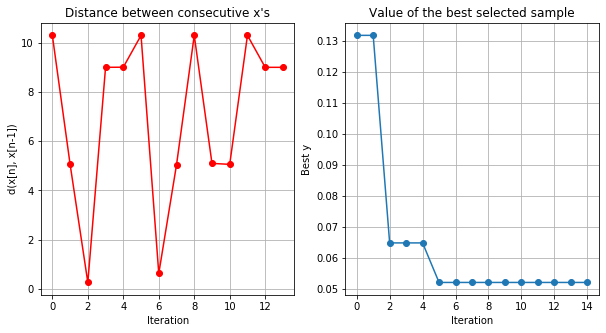

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.05215599307070997

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.46544535346334687
Cases Prevented:  36.36609351356786
Money Lost:  113560.68892690096
Total Cost:  0.05215599307070997
Cost per prevented hospitalization:  31227.07939045817
####################################################

----------------------------------------------------------------------------

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.26348778622945196


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.2960305055622693


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.24079940494710836


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.25063216860016285


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.24691972080445135
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.23584015324521526
num acquisition: 1, time elapsed: 8.73s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.23584040782477506
num acquisition: 2, time elapsed: 18.50s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 10]
total cost: 0.27087042714475207
num acquisition: 3, time elapsed: 32.58s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [7.877666372627593e-08, 0, 10]
total cost: 0.26582520202671717
num acquisition: 4, time elapsed: 43.44s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.23584040782477506
num acquisition: 5, time elapsed: 53.55s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.23584040782477506
num acquisition: 6, time elapsed: 62.52s


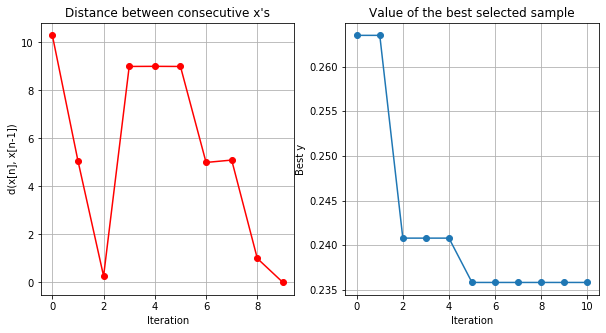

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.23584015324521526

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.46544535346334687
Cases Prevented:  36.36609351356786
Money Lost:  113560.68892690096
Total Cost:  0.23584015324521526
Cost per prevented hospitalization:  31227.07939045817
####################################################

----------------------------------------------------------------------------

lambda =  0.9
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.39514660078854924


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.44681512174116006


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.4166949906731024


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.4111092354976966


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.4138222848301461
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.3856503626969215
num acquisition: 1, time elapsed: 7.33s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.3856503626969215
num acquisition: 2, time elapsed: 14.74s


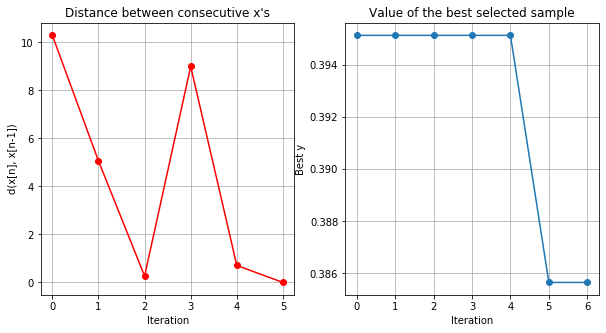

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.3856503626969215

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.4156066517831811
Cases Prevented:  40.303749655914395
Money Lost:  2113569.962526901
Total Cost:  0.3856503626969215
Cost per prevented hospitalization:  524410.2547706114
####################################################

####################################################
Configuration: S2_test_based_TTI
Cost function: total_cost_R
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
----------------------------------------------------------------------------

lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.12451405953542949


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.1374099840606109


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.057588907086189176


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.08284018956770386


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.07270224464383143
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.04484108093578477
num acquisition: 1, time elapsed: 6.98s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.049677897894372616
num acquisition: 2, time elapsed: 13.99s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.3801810939122313, 5, 10]
total cost: 0.10801355939122961
num acquisition: 3, time elapsed: 21.05s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.04484153917899238
num acquisition: 4, time elapsed: 28.12s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.04963372858292042
num acquisition: 5, time elapsed: 35.16s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.1386846796287115
num acquisition: 6, time elapsed: 42.47s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7803738055404612, 5, 1]
total cost: 0.07033227774964027
num acquisition: 7, time elapsed: 49.44s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9994590671864021, 0, 10]
total cost: 0.0448949981997841
num acquisition: 8, time elapsed: 56.71s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9979093217902862, 0, 1]
total cost: 0.04504769737145351
num acquisition: 9, time elapsed: 69.40s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9988260595142483, 0, 10]
total cost: 0.04495755674579261
num acquisition: 10, time elapsed: 80.55s


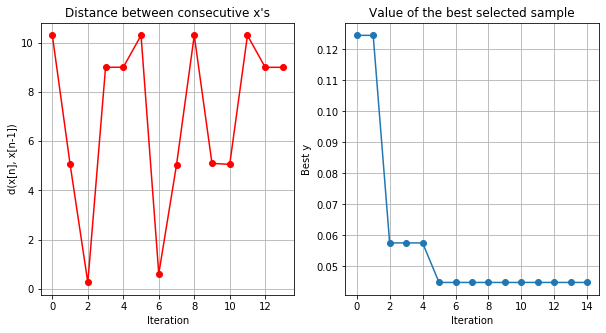

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.04484108093578477

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.3922962321140948
Cases Prevented:  42.14545929312957
Money Lost:  113560.68892690096
Total Cost:  0.04484108093578477
Cost per prevented hospitalization:  26944.94041150793
####################################################

----------------------------------------------------------------------------

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.22691322555482601


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.25685097894843123


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.20422484427248236


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.21405760792553688


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.2103451601298254
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.19926559257058923
num acquisition: 1, time elapsed: 7.19s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.19926584715014903
num acquisition: 2, time elapsed: 15.12s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.19926584715014903
num acquisition: 3, time elapsed: 22.67s


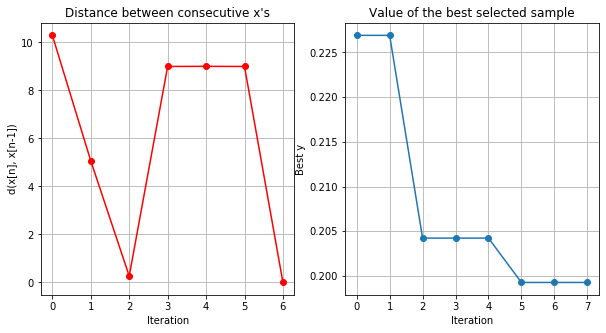

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.19926559257058923

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.3922962321140948
Cases Prevented:  42.14545929312957
Money Lost:  113560.68892690096
Total Cost:  0.19926559257058923
Cost per prevented hospitalization:  26944.94041150793
####################################################

----------------------------------------------------------------------------

lambda =  0.9
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.3293123915742226


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.37629197383625157


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.3508607814587756


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.34527502628336987


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.34798807561581935
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.3198161534825948
num acquisition: 1, time elapsed: 7.17s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.3198161534825948
num acquisition: 2, time elapsed: 18.09s


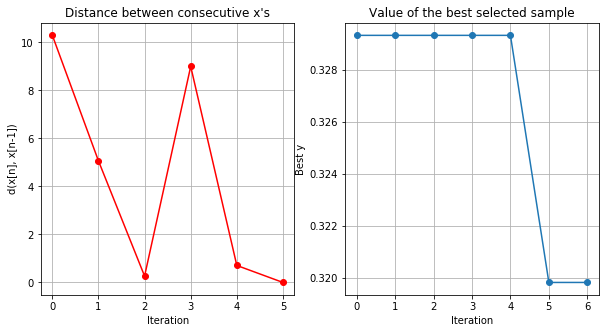

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.3198161534825948

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.3424575304339293
Cases Prevented:  46.08311543547612
Money Lost:  2113569.962526901
Total Cost:  0.3198161534825948
Cost per prevented hospitalization:  458643.02848322917
####################################################

####################################################
Configuration: S3_test_based_TTI
Cost function: total_cost_R
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
----------------------------------------------------------------------------

lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.11989263602417304


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.13221780135843825


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.05296748357493268


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.07821876605644737


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.06808082113257495
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.04021965742452828
num acquisition: 1, time elapsed: 11.53s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.04448571519219999
num acquisition: 2, time elapsed: 21.96s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.3916011688114838, 5, 10]
total cost: 0.10170794792791993
num acquisition: 3, time elapsed: 29.24s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.040220115667735895
num acquisition: 4, time elapsed: 36.49s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.04444154588074779
num acquisition: 5, time elapsed: 43.58s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.13406325611745504
num acquisition: 6, time elapsed: 50.75s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7844562453053817, 5, 1]
total cost: 0.06473663785872327
num acquisition: 7, time elapsed: 57.72s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9994590671864021, 0, 10]
total cost: 0.0402735746885276
num acquisition: 8, time elapsed: 64.98s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9979093217902862, 0, 1]
total cost: 0.04042627386019702
num acquisition: 9, time elapsed: 72.35s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9988260595142483, 0, 10]
total cost: 0.04033613323453612
num acquisition: 10, time elapsed: 79.84s


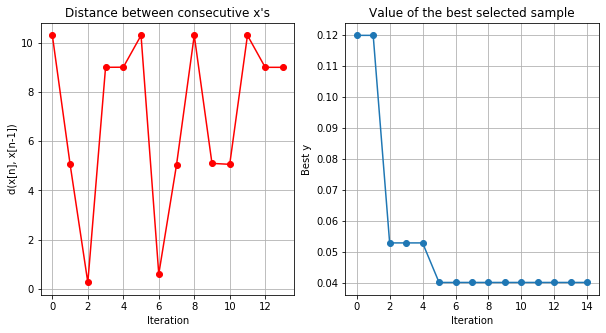

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.04021965742452828

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.34608199700153
Cases Prevented:  45.7967535809031
Money Lost:  113560.68892690096
Total Cost:  0.04021965742452828
Cost per prevented hospitalization:  24796.66789618356
####################################################

----------------------------------------------------------------------------

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.2038061079985437


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.23089006543756807


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.18111772671619988


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.19095049036925446


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.18723804257354293
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.17615847501430681
num acquisition: 1, time elapsed: 10.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.1761587295938666
num acquisition: 2, time elapsed: 17.79s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.1761587295938666
num acquisition: 3, time elapsed: 28.78s


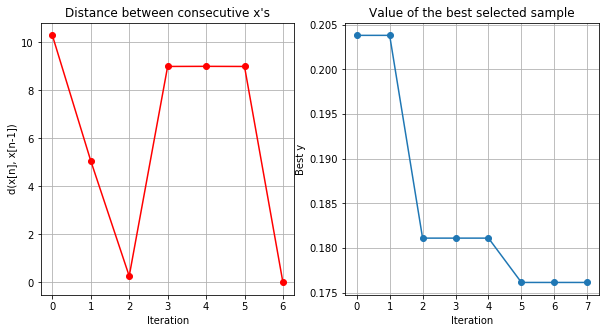

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.17615847501430681

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.34608199700153
Cases Prevented:  45.7967535809031
Money Lost:  113560.68892690096
Total Cost:  0.17615847501430681
Cost per prevented hospitalization:  24796.66789618356
####################################################

----------------------------------------------------------------------------

lambda =  0.9
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.2877195799729144


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.3295623295166979


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.30926796985746713


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.3036822146820615


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.30639526401451095
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.27822334188128656
num acquisition: 1, time elapsed: 7.44s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.27822334188128656
num acquisition: 2, time elapsed: 14.94s


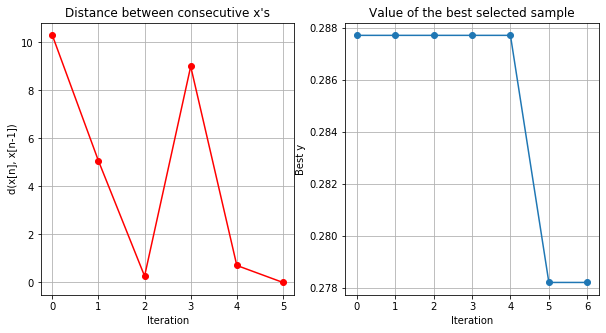

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.27822334188128656

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.29624329532136456
Cases Prevented:  49.73440972324963
Money Lost:  2113569.962526901
Total Cost:  0.27822334188128656
Cost per prevented hospitalization:  424971.3577155131
####################################################

####################################################
Configuration: S4_test_based_TTI
Cost function: total_cost_R
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
----------------------------------------------------------------------------

lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.11382231614445


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.12524773339030704


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.04689716369520969


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.07214844617672438


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.06201050125285194
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.034149337544805286
num acquisition: 1, time elapsed: 7.39s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.037515647224068756
num acquisition: 2, time elapsed: 14.78s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.4093995910113777, 5, 10]
total cost: 0.0932449635542915
num acquisition: 3, time elapsed: 22.30s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.0341497957880129
num acquisition: 4, time elapsed: 29.91s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.03747147791261656
num acquisition: 5, time elapsed: 37.23s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.127992936237732
num acquisition: 6, time elapsed: 44.72s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7912138735502685, 5, 1]
total cost: 0.05719054997461638
num acquisition: 7, time elapsed: 52.09s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9994590671864021, 0, 10]
total cost: 0.03420325480880461
num acquisition: 8, time elapsed: 59.82s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9979093217902862, 0, 1]
total cost: 0.03435595398047403
num acquisition: 9, time elapsed: 67.70s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9988260595142483, 0, 10]
total cost: 0.03426581335481313
num acquisition: 10, time elapsed: 75.50s


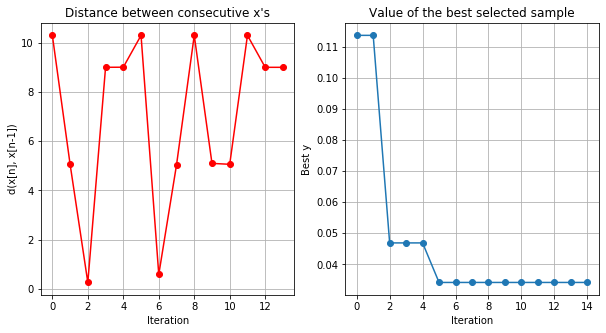

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.034149337544805286

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.2853787982043
Cases Prevented:  50.59279191147468
Money Lost:  113560.68892690096
Total Cost:  0.034149337544805286
Cost per prevented hospitalization:  22446.021386921104
####################################################

----------------------------------------------------------------------------

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.17345450859992853


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.19603972559691196


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.1507661273175849


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.16059889097063945


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.15688644317492795
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.14580687561569183
num acquisition: 1, time elapsed: 6.56s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.14580713019525163
num acquisition: 2, time elapsed: 13.39s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.14580713019525163
num acquisition: 3, time elapsed: 22.97s


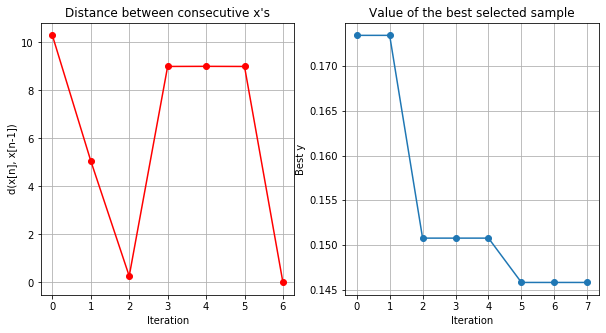

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.14580687561569183

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.2853787982043
Cases Prevented:  50.59279191147468
Money Lost:  113560.68892690096
Total Cost:  0.14580687561569183
Cost per prevented hospitalization:  22446.021386921104
####################################################

----------------------------------------------------------------------------

lambda =  0.9
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.23308670105540708


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.2668317178035169


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.2546350909399602


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.24904933576455454


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.25176238509700394
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.2235904629637793
num acquisition: 1, time elapsed: 9.41s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.2235904629637793
num acquisition: 2, time elapsed: 19.26s


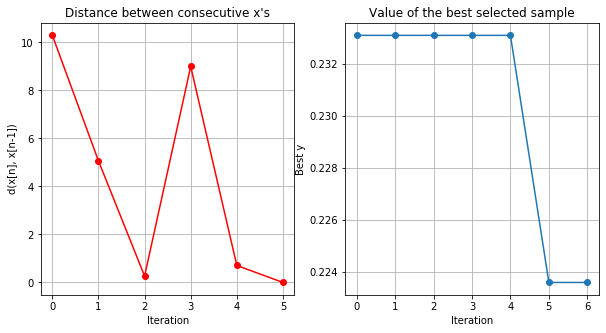

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.2235904629637793

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.23554009652413424
Cases Prevented:  54.53044805382121
Money Lost:  2113569.962526901
Total Cost:  0.2235904629637793
Cost per prevented hospitalization:  387594.46106894646
####################################################

####################################################
Configuration: S5_test_based_TTI
Cost function: total_cost_R
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
----------------------------------------------------------------------------

lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.10681992668654147


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.11658863080212342


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.03989477423730115


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.06514605671881585


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.055008111794943415
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.027146948086896758
num acquisition: 1, time elapsed: 7.12s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.028856544635885155
num acquisition: 2, time elapsed: 14.29s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.44161326254874694, 5, 10]
total cost: 0.0815956169147209
num acquisition: 3, time elapsed: 21.82s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.027147406330104373
num acquisition: 4, time elapsed: 31.32s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.02881237532443296
num acquisition: 5, time elapsed: 39.77s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.794880961984899, 5, 1]
total cost: 0.04816903831834901
num acquisition: 6, time elapsed: 48.97s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.12099054677982346
num acquisition: 7, time elapsed: 56.95s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9994590671864021, 0, 10]
total cost: 0.02720086535089608
num acquisition: 8, time elapsed: 64.55s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9979093217902862, 0, 1]
total cost: 0.027353564522565495
num acquisition: 9, time elapsed: 74.07s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9988260595142483, 0, 10]
total cost: 0.027263423896904598
num acquisition: 10, time elapsed: 81.68s


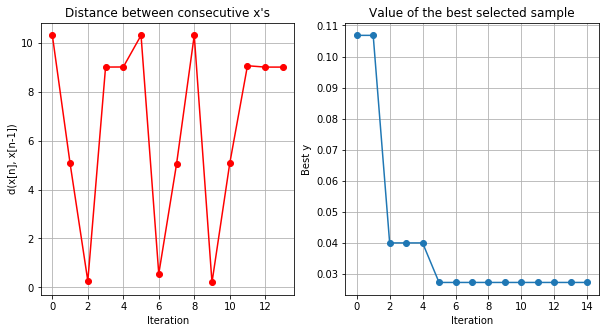

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.027146948086896758

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.2153549036252147
Cases Prevented:  56.12523977437904
Money Lost:  113560.68892690096
Total Cost:  0.027146948086896758
Cost per prevented hospitalization:  20233.443880758434
####################################################

----------------------------------------------------------------------------

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.1384425613103859


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.15274421265599394


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.11575418002804225


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.1255869436810968


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.12187449588538529
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.11079492832614918
num acquisition: 1, time elapsed: 11.83s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995838123771649, 5, 10]
total cost: 0.1276069846658856
num acquisition: 2, time elapsed: 23.84s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 5, 10]
total cost: 0.15162584767552495
num acquisition: 3, time elapsed: 36.25s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.11079518290570896
num acquisition: 4, time elapsed: 48.28s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.11079492832614918
num acquisition: 5, time elapsed: 60.92s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.11079492832614918
num acquisition: 6, time elapsed: 73.10s


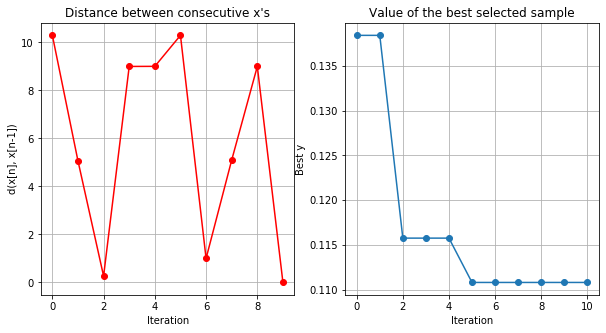

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.11079492832614918

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 0, 1]
Effective R: 0.2153549036252147
Cases Prevented:  56.12523977437904
Money Lost:  113560.68892690096
Total Cost:  0.11079492832614918
Cost per prevented hospitalization:  20233.443880758434
####################################################

----------------------------------------------------------------------------

lambda =  0.9
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.17006519593423036


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.18889979450986444


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.19161358581878338


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.18602783064337775


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.18874087997582717
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.07682535164454894, 0, 10]
total cost: 0.1682205645262272
num acquisition: 1, time elapsed: 12.10s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.1605689578426025
num acquisition: 2, time elapsed: 23.99s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.1605689578426025
num acquisition: 3, time elapsed: 35.98s


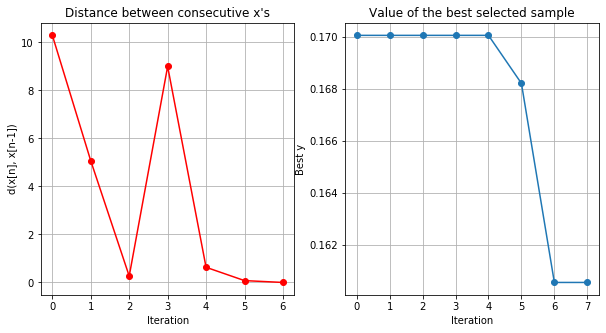

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: 0.1605689578426025

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.16551620194504893
Cases Prevented:  60.06289591672559
Money Lost:  2113569.962526901
Total Cost:  0.1605689578426025
Cost per prevented hospitalization:  351892.78343442973
####################################################



In [17]:
for name in ["S1_test_based_TTI", "S2_test_based_TTI", "S3_test_based_TTI", "S4_test_based_TTI", "S5_test_based_TTI"]:
    print("####################################################")
    # define config file for each simulation
    case_config = config.get_case_config("delve")
    contacts_config = config.get_contacts_config("delve")
    policy_config = config.get_strategy_configs("delve", name)[name]
    configs = {"case_config": case_config, "contacts_config": contacts_config, "policy_config": policy_config}
    
    print("Configuration:", name)
    print("Cost function:", "total_cost_R")
    print("Optimizing: ", [config_details[i]["name"] for i in range(3)])
    
    # run the optimization for different values of lambda
    for l in [0.1, 0.5, 0.9]:
        lam = l
        print("----------------------------------------------------------------------------") ; print()
        print("lambda = ", lam)
        optimize(cost_function=total_cost_R)
        print("####################################################") ; print()

## Cost Function takes into account number of cases prevented and money lost

Configuration: S1_test_based_TTI
Cost function: total_cost_cases_prevented
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.08900318136129247


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.09677733193822886


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.01881855877437047


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.045013506811172825


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.0344437901603619
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.005593274677618501
num acquisition: 1, time elapsed: 7.76s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.0037363868020789917
num acquisition: 2, time elapsed: 18.51s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.47746083540456025, 5, 10]
total cost: 0.05533302435851645
num acquisition: 3, time elapsed: 27.62s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0036922174906268
num acquisition: 4, time elapsed: 35.07s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8090878288262279, 5, 1]
total cost: 0.022559240504247704
num acquisition: 5, time elapsed: 42.51s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.005593732920826116
num acquisition: 6, time elapsed: 49.91s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.10441877471049062
num acquisition: 7, time elapsed: 57.28s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.08551435362770987
num acquisition: 8, time elapsed: 64.89s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.023315988853764465
num acquisition: 9, time elapsed: 75.19s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.05085373568026448
num acquisition: 10, time elapsed: 86.21s


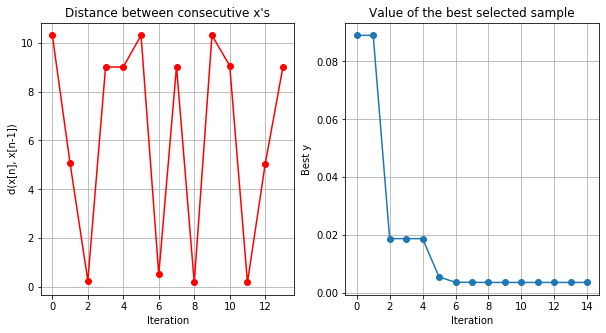

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0036922174906268

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.5376208458895726
Cases Prevented:  30.66365220795672
Money Lost:  75030.7451857852
Total Cost:  0.0036922174906268
Cost per prevented hospitalization:  24468.952581687558
####################################################

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.04935883468414086


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.053687718336521126


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.01037310271338884


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.024924194142881707


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.019052887712477713
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.0030265612797579053
num acquisition: 1, time elapsed: 7.62s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.002007628996248425
num acquisition: 2, time elapsed: 14.81s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.47731489912631686, 5, 10]
total cost: 0.0306765539548342
num acquisition: 3, time elapsed: 21.89s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.001983090489886096
num acquisition: 4, time elapsed: 29.65s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8090726727173518, 5, 1]
total cost: 0.012464074794140443
num acquisition: 5, time elapsed: 37.79s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.003026815859317691
num acquisition: 6, time elapsed: 44.86s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.057920866506592755
num acquisition: 7, time elapsed: 51.47s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.047421073167221314
num acquisition: 8, time elapsed: 58.72s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.01288357966555424
num acquisition: 9, time elapsed: 65.57s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.028180297660000894
num acquisition: 10, time elapsed: 74.41s


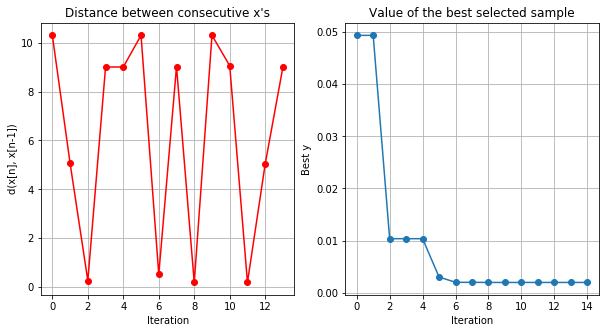

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.001983090489886096

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.5376208458895726
Cases Prevented:  30.66365220795672
Money Lost:  75030.7451857852
Total Cost:  0.001983090489886096
Cost per prevented hospitalization:  24468.952581687558
####################################################

lambda =  1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: -0.00019659866229863488


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: -0.00017429866561354516


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: -0.00018371736283819836


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: -0.0001874466924821893


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: -0.00018574034737752133
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00020151874827957196
num acquisition: 1, time elapsed: 9.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00020151874827957196
num acquisition: 2, time elapsed: 18.41s


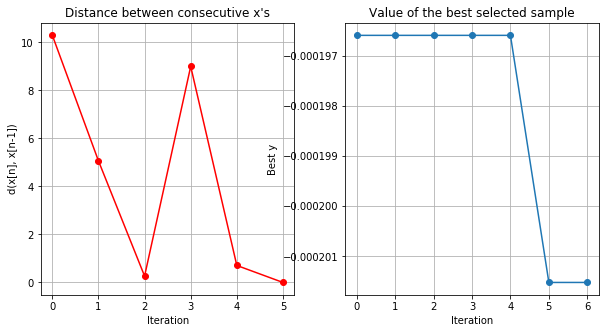

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00020151874827957196

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.4156066517831811
Cases Prevented:  40.303749655914395
Money Lost:  2113569.962526901
Total Cost:  -0.00020151874827957196
Cost per prevented hospitalization:  524410.2547706114
####################################################

Configuration: S2_test_based_TTI
Cost function: total_cost_cases_prevented
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.08900029167840268


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.09677423644219016


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.018815669091480688


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.04501061712828305


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.03444090047747212
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.00559038499472872
num acquisition: 1, time elapsed: 11.57s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.0037332913060402857
num acquisition: 2, time elapsed: 22.91s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.4774625013254533, 5, 10]
total cost: 0.05532976422373255
num acquisition: 3, time elapsed: 33.67s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.003689121994588094
num acquisition: 4, time elapsed: 47.02s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8090879620140425, 5, 1]
total cost: 0.02255613184559439
num acquisition: 5, time elapsed: 55.07s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.0055908432379363346
num acquisition: 6, time elapsed: 62.46s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.10441588502760084
num acquisition: 7, time elapsed: 71.15s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.08551146394482009
num acquisition: 8, time elapsed: 81.69s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.023312893357725756
num acquisition: 9, time elapsed: 93.40s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.05085064018422577
num acquisition: 10, time elapsed: 105.35s


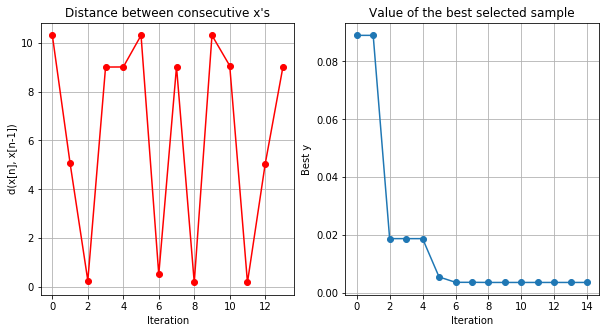

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.003689121994588094

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.45926179266189643
Cases Prevented:  36.854644285368934
Money Lost:  75030.7451857852
Total Cost:  0.003689121994588094
Cost per prevented hospitalization:  20358.559047488063
####################################################

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.04934438626969196


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.053672240856327595


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.010358654298939935


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.024909745728432804


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.019038439298028807
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.003012112865309001
num acquisition: 1, time elapsed: 8.86s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.0019921515160548947
num acquisition: 2, time elapsed: 15.67s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.4773299171435833, 5, 10]
total cost: 0.030660251923177475
num acquisition: 3, time elapsed: 22.53s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019676130096925658
num acquisition: 4, time elapsed: 29.51s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8090738734648245, 5, 1]
total cost: 0.01244853138792832
num acquisition: 5, time elapsed: 36.33s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.003012367444868787
num acquisition: 6, time elapsed: 45.96s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.05790641809214385
num acquisition: 7, time elapsed: 54.64s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.04740662475277241
num acquisition: 8, time elapsed: 63.58s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.012868102185360709
num acquisition: 9, time elapsed: 74.41s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.028164820179807364
num acquisition: 10, time elapsed: 83.89s


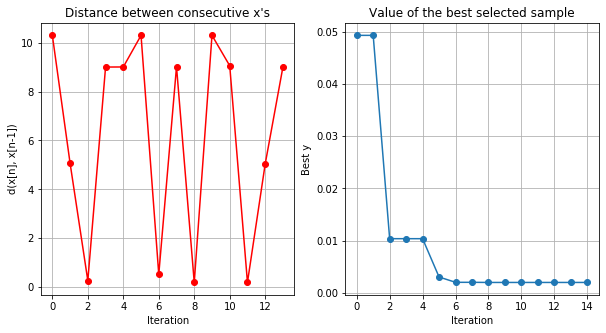

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019676130096925658

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.45926179266189643
Cases Prevented:  36.854644285368934
Money Lost:  75030.7451857852
Total Cost:  0.0019676130096925658
Cost per prevented hospitalization:  20358.559047488063
####################################################

lambda =  1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: -0.00022549549119644347


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: -0.00020525362600060625


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: -0.00021261419173600687


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: -0.00021634352137999785


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: -0.00021463717627532983
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00023041557717738058
num acquisition: 1, time elapsed: 6.99s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00023041557717738058
num acquisition: 2, time elapsed: 13.98s


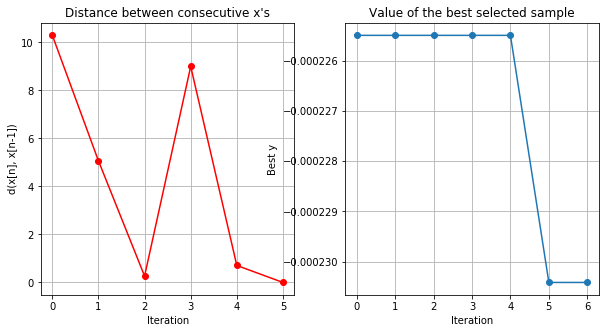

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00023041557717738058

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.3424575304339293
Cases Prevented:  46.08311543547612
Money Lost:  2113569.962526901
Total Cost:  -0.00023041557717738058
Cost per prevented hospitalization:  458643.02848322917
####################################################

Configuration: S3_test_based_TTI
Cost function: total_cost_cases_prevented
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.0889984660312588


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.09677218532233549


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.0188138434443368


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.045008791481139156


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.03443907483032824
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.005588559347584833
num acquisition: 1, time elapsed: 7.14s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.0037312401861856197
num acquisition: 2, time elapsed: 14.26s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.47746432636149944, 5, 10]
total cost: 0.055327532740184864
num acquisition: 3, time elapsed: 21.51s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.003687070874733428
num acquisition: 4, time elapsed: 28.82s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8090881079214626, 5, 1]
total cost: 0.022554066306078716
num acquisition: 5, time elapsed: 35.94s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.005589017590792448
num acquisition: 6, time elapsed: 43.25s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.10441405938045695
num acquisition: 7, time elapsed: 50.31s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.0855096382976762
num acquisition: 8, time elapsed: 57.83s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.02331084223787109
num acquisition: 9, time elapsed: 65.32s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.050848589064371105
num acquisition: 10, time elapsed: 72.72s


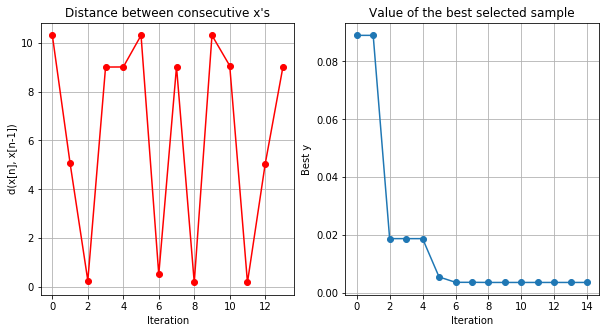

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.003687070874733428

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.4073399656401701
Cases Prevented:  40.95688399470146
Money Lost:  75030.7451857852
Total Cost:  0.003687070874733428
Cost per prevented hospitalization:  18319.446663836006
####################################################

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.049335258033972526


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.05366198525705426


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.010349526063220501


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.02490061749271337


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.019029311062309373
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.0030029846295895673
num acquisition: 1, time elapsed: 6.98s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.0019818959167815634
num acquisition: 2, time elapsed: 14.05s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.47734636806011954, 5, 10]
total cost: 0.030649093100325406
num acquisition: 3, time elapsed: 21.19s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019573574104192345
num acquisition: 4, time elapsed: 28.31s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.809075188700298, 5, 1]
total cost: 0.012438203576770097
num acquisition: 5, time elapsed: 35.43s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.003003239209149353
num acquisition: 6, time elapsed: 42.55s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.05789728985642442
num acquisition: 7, time elapsed: 49.50s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.047397496517052974
num acquisition: 8, time elapsed: 56.77s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.012857846586087377
num acquisition: 9, time elapsed: 64.18s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.02815456458053403
num acquisition: 10, time elapsed: 71.61s


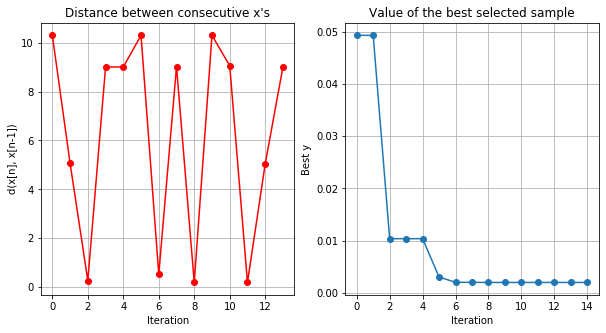

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019573574104192345

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.4073399656401701
Cases Prevented:  40.95688399470146
Money Lost:  75030.7451857852
Total Cost:  0.0019573574104192345
Cost per prevented hospitalization:  18319.446663836006
####################################################

lambda =  1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: -0.0002437519626353111


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: -0.00022576482454726886


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: -0.00023087066317487454


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: -0.00023459999281886553


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: -0.00023289364771419748
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.016180755621457443, 0, 10]
total cost: -0.000247830062150478
num acquisition: 1, time elapsed: 8.17s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00024867204861624815
num acquisition: 2, time elapsed: 14.77s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.007463140417219405, 5, 10]
total cost: -0.0002285082133531942
num acquisition: 3, time elapsed: 23.67s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: -0.00024867204861624815
num acquisition: 4, time elapsed: 33.31s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 10]
total cost: -0.0002047844199735073
num acquisition: 5, time elapsed: 42.44s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: -0.00024867204861624815
num acquisition: 6, time elapsed: 50.31s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: -0.0002047844199735073
num acquisition: 7, time elapsed: 58.73s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.16341984514690305, 0, 1]
total cost: -0.0002437519626353111
num acquisition: 8, time elapsed: 70.21s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: -0.00022898376790451551
num acquisition: 9, time elapsed: 78.94s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.403289887147459, 5, 10]
total cost: -0.00021520108916939573
num acquisition: 10, time elapsed: 87.71s


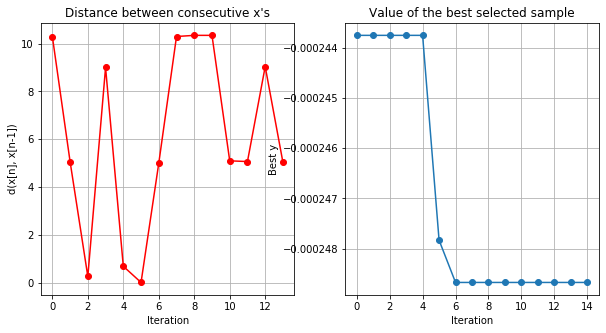

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00024867204861624815

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.29624329532136456
Cases Prevented:  49.73440972324963
Money Lost:  2113569.962526901
Total Cost:  -0.00024867204861624815
Cost per prevented hospitalization:  424971.3577155131
####################################################

Configuration: S4_test_based_TTI
Cost function: total_cost_cases_prevented
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.0889960680120935


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.09676943186668535


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.018811445425171516


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.045006393461973875


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.03443667681116295
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.005586161328419548
num acquisition: 1, time elapsed: 6.62s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.003728486730535489
num acquisition: 2, time elapsed: 15.66s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.47746720332517395, 5, 10]
total cost: 0.05532449496149679
num acquisition: 3, time elapsed: 24.96s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.003684317419083297
num acquisition: 4, time elapsed: 38.56s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8090883379254838, 5, 1]
total cost: 0.022551290119713335
num acquisition: 5, time elapsed: 47.10s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.005586619571627162
num acquisition: 6, time elapsed: 54.32s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.10441166136129167
num acquisition: 7, time elapsed: 61.43s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.08550724027851092
num acquisition: 8, time elapsed: 70.68s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.02330808878222096
num acquisition: 9, time elapsed: 79.63s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.050845835608720975
num acquisition: 10, time elapsed: 94.28s


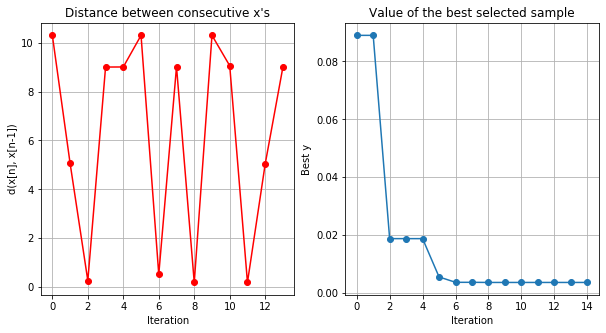

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.003684317419083297

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.33763928595885784
Cases Prevented:  46.463795294962566
Money Lost:  75030.7451857852
Total Cost:  0.003684317419083297
Cost per prevented hospitalization:  16148.217060072953
####################################################

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.04932326793814609


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.053648217978803606


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.010337535967394071


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.02488862739688694


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.019017320966482947
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.002990994533763138
num acquisition: 1, time elapsed: 7.50s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.0019681286385309104
num acquisition: 2, time elapsed: 17.83s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.47737229789203073, 5, 10]
total cost: 0.030633902166710438
num acquisition: 3, time elapsed: 29.53s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019435901321685814
num acquisition: 4, time elapsed: 39.72s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.809077261605319, 5, 1]
total cost: 0.012424322487432549
num acquisition: 5, time elapsed: 49.67s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.0029912491133229245
num acquisition: 6, time elapsed: 59.44s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.05788529976059799
num acquisition: 7, time elapsed: 68.79s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.04738550642122655
num acquisition: 8, time elapsed: 77.41s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.012844079307836724
num acquisition: 9, time elapsed: 88.16s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.02814079730228338
num acquisition: 10, time elapsed: 97.00s


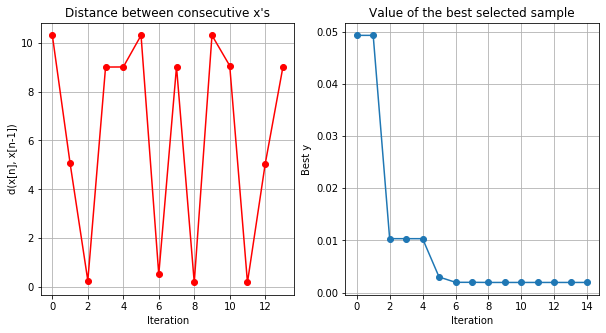

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019435901321685814

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.33763928595885784
Cases Prevented:  46.463795294962566
Money Lost:  75030.7451857852
Total Cost:  0.0019435901321685814
Cost per prevented hospitalization:  16148.217060072953
####################################################

lambda =  1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: -0.00026773215428816896


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: -0.0002532993810485744


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: -0.00025485085482773246


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: -0.0002585801844717234


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: -0.00025687383936705537
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.14197576610556345, 0, 10]
total cost: -0.0002677321542881689
num acquisition: 1, time elapsed: 7.92s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.005313475668345946, 5, 10]
total cost: -0.0002563427698544997
num acquisition: 2, time elapsed: 15.17s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00027265224026910606
num acquisition: 3, time elapsed: 24.08s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00027265224026910606
num acquisition: 4, time elapsed: 33.59s


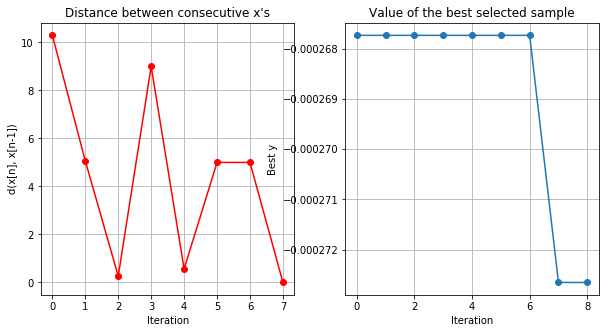

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00027265224026910606

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.23554009652413424
Cases Prevented:  54.53044805382121
Money Lost:  2113569.962526901
Total Cost:  -0.00027265224026910606
Cost per prevented hospitalization:  387594.46106894646
####################################################

Configuration: S5_test_based_TTI
Cost function: total_cost_cases_prevented
Optimizing:  ['go_to_school_prob', 'testing_delay', 'quarantine_length']
lambda =  0.1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.08899330178816206


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.09676601117479892


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.01880867920124006


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.045003627238042423


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.0344339105872315
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.005583395104488095
num acquisition: 1, time elapsed: 7.55s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.003725066038649053
num acquisition: 2, time elapsed: 15.05s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.4774725005924917, 5, 10]
total cost: 0.055320550754089454
num acquisition: 3, time elapsed: 26.54s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0036808967271968612
num acquisition: 4, time elapsed: 34.01s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8090887614150323, 5, 1]
total cost: 0.022547827575426737
num acquisition: 5, time elapsed: 41.56s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.00558385334769571
num acquisition: 6, time elapsed: 48.86s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.10440889513736021
num acquisition: 7, time elapsed: 61.15s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.08550447405457946
num acquisition: 8, time elapsed: 69.10s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.023304668090334525
num acquisition: 9, time elapsed: 76.99s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.05084241491683454
num acquisition: 10, time elapsed: 84.43s


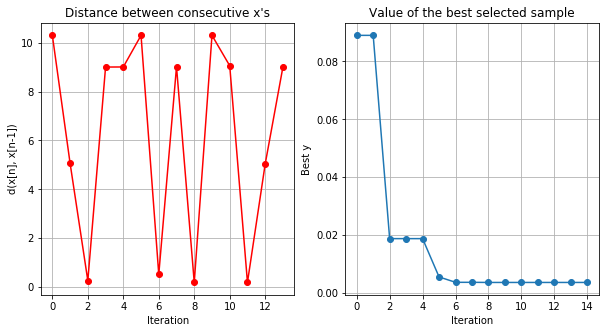

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0036808967271968612

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.2510482600770218
Cases Prevented:  53.305179067834665
Money Lost:  75030.7451857852
Total Cost:  0.0036808967271968612
Cost per prevented hospitalization:  14075.695175942134
####################################################

lambda =  0.5
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: 0.04930943681848883


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: 0.05363111451937143


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: 0.01032370484773681


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: 0.024874796277229678


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: 0.019003489846825684
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 1]
total cost: 0.0029771634141058773
num acquisition: 1, time elapsed: 7.21s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.9995577032504386, 5, 10]
total cost: 0.00195102517909873
num acquisition: 2, time elapsed: 14.43s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.47742003152777224, 5, 10]
total cost: 0.030614177932611664
num acquisition: 3, time elapsed: 21.66s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019264866727364011
num acquisition: 4, time elapsed: 29.89s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.809081077050668, 5, 1]
total cost: 0.012407009544219024
num acquisition: 5, time elapsed: 41.83s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 0, 10]
total cost: 0.002977417993665663
num acquisition: 6, time elapsed: 49.51s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 1]
total cost: 0.057871468640940726
num acquisition: 7, time elapsed: 57.12s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.19129317420210723, 0, 1]
total cost: 0.047371675301569285
num acquisition: 8, time elapsed: 65.07s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.801430382208645, 5, 1]
total cost: 0.012826975848404545
num acquisition: 9, time elapsed: 73.42s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.5227857330514172, 5, 10]
total cost: 0.0281236938428512
num acquisition: 10, time elapsed: 81.08s


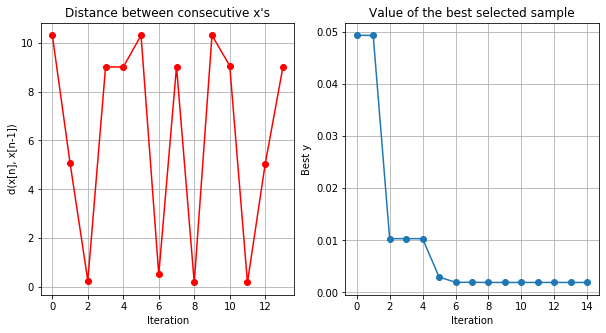

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [1.0, 5, 1]
total cost: 0.0019264866727364011

####################################################
Key Performance Indicators
####################################################
Optimal value: [1.0, 5, 1]
Effective R: 0.2510482600770218
Cases Prevented:  53.305179067834665
Money Lost:  75030.7451857852
Total Cost:  0.0019264866727364011
Cost per prevented hospitalization:  14075.695175942134
####################################################

lambda =  1
Setting up optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.15599452033620265, 0, 10]
total cost: -0.00029539439360269084


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.05808361216819946, 5, 1]
total cost: -0.0002875062999129349


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.8661761457749352, 0, 1]
total cost: -0.00028251309414225424


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.6011150117432088, 0, 1]
total cost: -0.0002862424237862452


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.7080725777960455, 0, 10]
total cost: -0.00028453607868157726
Starting optimization...


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.07531258803346563, 0, 10]
total cost: -0.0002965856475119477
num acquisition: 1, time elapsed: 10.75s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00030031447958362795
num acquisition: 2, time elapsed: 23.41s


  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00030031447958362795
num acquisition: 3, time elapsed: 30.84s


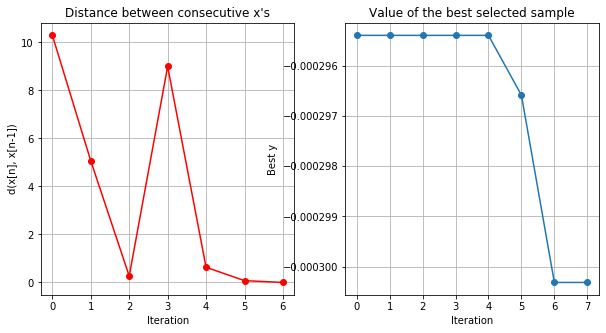

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

theta: [0.0, 0, 10]
total cost: -0.00030031447958362795

####################################################
Key Performance Indicators
####################################################
Optimal value: [0.0, 0, 10]
Effective R: 0.16551620194504893
Cases Prevented:  60.06289591672559
Money Lost:  2113569.962526901
Total Cost:  -0.00030031447958362795
Cost per prevented hospitalization:  351892.78343442973
####################################################



In [19]:
for name in ["S1_test_based_TTI", "S2_test_based_TTI", "S3_test_based_TTI", "S4_test_based_TTI", "S5_test_based_TTI"]:

    # define config file for each simulation
    case_config = config.get_case_config("delve")
    contacts_config = config.get_contacts_config("delve")
    policy_config = config.get_strategy_configs("delve", name)[name]
    configs = {"case_config": case_config, "contacts_config": contacts_config, "policy_config": policy_config}
    
    print("Configuration:", name)
    print("Cost function:", "total_cost_cases_prevented")
    print("Optimizing: ", [config_details[i]["name"] for i in range(3)])
    
    # run the optimization for different values of lambda
    for l in [0.1, 0.5, 1]:
        lam = l
        print("lambda = ", lam)
        optimize(cost_function=total_cost_cases_prevented)
        print("####################################################")
        print()